# Universal noise

This notebook computes a universal noise pattern, which can be added to any image 
and missleads the open pose network 

In [1]:
%load_ext autoreload
%autoreload 2
# imports
import datetime
import logging
import os
import pathlib
import sys

import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm
from utils import compare_poses

from loss_functions import multi_stage_loss
from plot_utils import gen_plot_universal_noise, plot_pose
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator,PoseEstimator
from tf_pose.networks import get_graph_path
from utils import load_batch
import glob 
import wandb

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)
logging.getLogger("wandb").setLevel(logging.ERROR)

In [2]:
image_path_targets = []
for file in glob.glob("../data/generated/*.xml"):
    filename, file_extension = os.path.splitext(file)
    image_path_targets.append(filename)
    
image_path_targets.reverse()
print(f'Found {len(image_path_targets)} images')

Found 20 images


In [3]:
# only use a single file for the beginning
# image_path_targets = ["../data/generated/a_4_9e56930f-83d5-4ae9-8a59-8d01e68fc073"]

In [4]:
# params 432, 368
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
TEST_CNT = 20
NOISE_WIDTH, NOISE_HEIGHT = 200, 400
RESIZE_OUT_RATIO = 2.0

image_path_targets = image_path_targets[:TEST_CNT]

image_targets = [common.read_imgfile(f'{image_path_target}.jpg', IMAGE_WIDTH, IMAGE_HEIGHT) 
                 for image_path_target in image_path_targets]
image_masks = [common.read_imgfile(f'{image_path_target}_mask.png', IMAGE_WIDTH, IMAGE_HEIGHT, cv2.IMREAD_GRAYSCALE) > 0 
               for image_path_target in image_path_targets]
image_masks = [np.array(np.repeat(mask[:, :, np.newaxis], 3, 2)) 
               for mask in image_masks]
image_transforms = [np.load(f'{image_path_target}_warp.npy')  
                    for image_path_target in image_path_targets]
model = 'cmu'
log_dir = '../logs/'


summary_writer = tf.summary.FileWriter(
    log_dir + "uniadv_rendering_2d_warp_train/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
test_texture = common.read_imgfile(f'data_set_creator/testBG.jpg', NOISE_WIDTH, NOISE_HEIGHT)

In [5]:
# the input image
sample_tensor = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='sample'
)

# the current universal noise
universal_noise_tensor = tf.placeholder(
    tf.float32,
    shape=(None, None, None, 3),
    name='universal_noise'
)

# create a placeholder for the transform
transforms_tensor = tf.placeholder(
    tf.float32,
    shape=(None, 8),
    name='2d_transform'
)

mask_tensor = tf.placeholder(
    tf.bool,
    shape=(None, None, None, 3),
    name='mask'
)

# warp the noise 
warped_universal_noise_tensor = tf.contrib.image.transform(
    universal_noise_tensor,
    transforms_tensor,
    interpolation='NEAREST',
    output_shape=(IMAGE_HEIGHT, IMAGE_WIDTH),
    name='warped_universal_noise'
)


ax_input_overwrite_tensor = tf.where(
    mask_tensor,
    warped_universal_noise_tensor,
    sample_tensor,
    name='ax_input_overwrite'
)

In [6]:
estimator = TfPoseEstimator(
    get_graph_path(model), 
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
    trt_bool=False, input_overwrite_tensor=ax_input_overwrite_tensor, sample_image=sample_tensor)
summary_writer.add_graph(estimator.graph)

With input overwrite


In [7]:
image_target = image_targets[0]

UPSAMPLE_SIZE = np.array([int(estimator.target_size[1] / 8 * RESIZE_OUT_RATIO),
                 int(estimator.target_size[0] / 8 * RESIZE_OUT_RATIO)])
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf = estimator.persistent_sess.run(
    [estimator.tensor_output, estimator.tensor_heatMat_up,
        estimator.tensor_pafMat_up],
    feed_dict={
        # the current sample image 
        sample_tensor: [image_target],
        # the current universal noise
        universal_noise_tensor: [np.zeros((NOISE_HEIGHT, NOISE_WIDTH, 3))],
        # the current 2d warp
        transforms_tensor: [[1, 0, 0, 0, 1, 0, 0, 0]],
        # the upsample size
        estimator.upsample_size: UPSAMPLE_SIZE, 
        mask_tensor: [np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3))]
    }
)

inference with overwrite


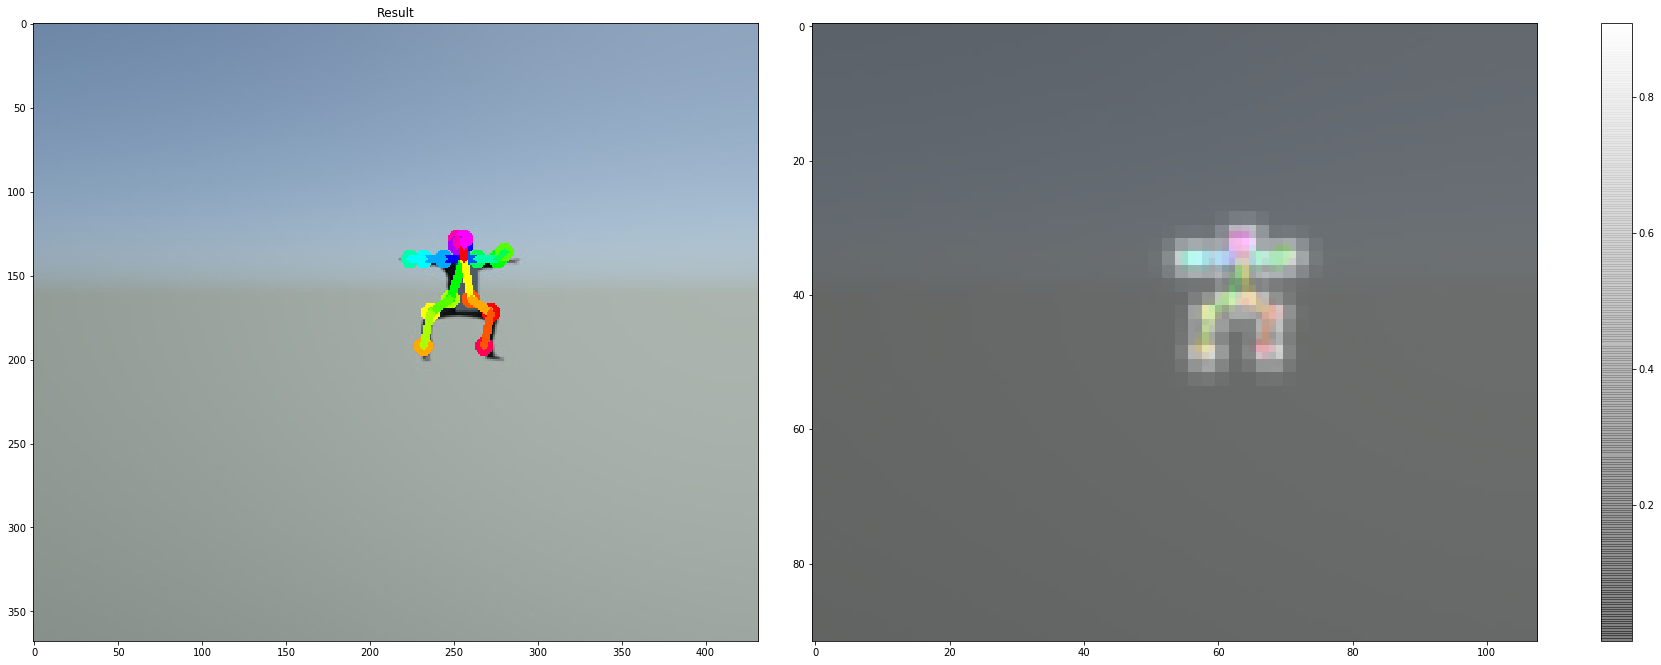

In [8]:
human_target = estimator.inference(
    image_target, resize_to_default=True, upsample_size=RESIZE_OUT_RATIO)
plot_pose(image_target, human_target, estimator.heatMat)

In [28]:
def wandb_init(image_target, universal_noise_filename, mask, current_transform):
    run = wandb.init(
        project = "2d_warp_single_images", 
        reinit = True,
        name = universal_noise_filename,
        config={
            "steps": 1000,
            "epsilon": 5000,
            "upsample_size_0": UPSAMPLE_SIZE[0],
            "upsample_size_1": UPSAMPLE_SIZE[1],
            "batch_size": 16,
            "image_width": IMAGE_WIDTH,
            "image_height": IMAGE_HEIGHT,
            "noise_width": NOISE_WIDTH,
            "noise_height": NOISE_HEIGHT,
        }
    )
    
    with run:
        run.log({
            "mask": wandb.Image(mask, caption='mask'),
            "image_target": wandb.Image(image_target, caption='image_target')
        })
    return run 

def multi_stage_loss_with_2D_warp(estimator, target_heat, target_paf, universal_noise_tensor):
    losses_per_stage = []
    stage = 6
    # compute loss per stage
    
    paf_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
    heat_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd').outputs[0]

    # compute the loss for every channel
    loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1) - tf.concat(target_paf, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage%d_' % (stage))

    # combined loss form every stage
    total_loss = tf.reduce_sum([loss_paf, loss_heat])
    # TODO delete: summary = tf.summary.scalar('total_loss', total_loss)

    grad = tf.gradients(total_loss, universal_noise_tensor)[0]
    return grad, total_loss,

def get_universal_noise(estimator, image_target, universal_noise_filename, mask, current_transform):
    cur_run = wandb_init(image_target, universal_noise_filename, mask, current_transform)
    with cur_run:
        upsample_size = [cur_run.config.upsample_size_0, cur_run.config.upsample_size_0]

        # get all outputs as np matrix
        target_np_heat = np.zeros((1, 46, 54, 19))
        target_np_paf = np.zeros((1, 46, 54, 38))

        # where does the current batch start
        training_stats = {
            'universal_noise': np.zeros((NOISE_HEIGHT, NOISE_WIDTH, 3)),
            'file_name': f'../snapshots/{universal_noise_filename}.npy'
        }

        target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
        target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))
        grad_func, loss_func = multi_stage_loss_with_2D_warp(
            estimator, 
            target_heat, 
            target_paf, 
            universal_noise_tensor)

        ### ================= TRAINING ================= ###
        for step in tqdm(range(cur_run.config.steps)):
            feed_dict = {
                # the target heatmap
                target_heat: target_np_heat,
                # the target paf
                target_paf: target_np_paf,
                # the current sample image 
                sample_tensor: [image_target],
                # the current universal noise
                universal_noise_tensor: [training_stats['universal_noise']],
                # the current 2d warp
                transforms_tensor: [current_transform],
                # the upsample size
                estimator.upsample_size: upsample_size,
                mask_tensor: [mask]
            }


            gradient, loss = estimator.persistent_sess.run(
                [grad_func, loss_func],
                feed_dict=feed_dict
            )
        
            
            wandb.log({'loss': loss}, step=step)

            if step % 100 == 0:
                # save universal noise
                np.save(training_stats['file_name'], training_stats['universal_noise'])
                wandb.log({
                    'universal_noise': wandb.Image(
                        np.clip(training_stats['universal_noise'], 0, 255), 
                        caption='universal noise'
                    )
                }, step=step)

            ### ================= UPDATE STEP ================= ###
            scaled_gradient = (cur_run.config.epsilon * gradient[0])
            training_stats['universal_noise'] = training_stats['universal_noise'] - scaled_gradient
            training_stats['universal_noise'] = np.clip(training_stats['universal_noise'], 0, 255)


    return training_stats['universal_noise']

In [29]:
universal_noises = []
universal_noise_filenames = [f'{image_path_target}_uni_noise' for image_path_target in image_path_targets]

In [30]:
for (i, image_target) in enumerate(image_targets):
    universal_noises.append(
        get_universal_noise(
            estimator, 
            image_target, 
            universal_noise_filenames[i], 
            image_masks[i], 
            image_transforms[i]
        ))

2020-03-09 23:35:52,275 INFO system metrics and metadata threads started
2020-03-09 23:35:52,277 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:35:52,511 INFO resuming run from id: UnVuOnYxOjFwNDV3Z2lhOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:35:52,525 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:35:52,734 INFO saving patches
2020-03-09 23:35:53,005 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223551-1p45wgia/config.yaml
2020-03-09 23:35:53,711 INFO saving pip packages
2020-03-09 23:35:53,716 INFO initializing streaming files api
2020-03-09 23:35:53,719 INFO unblocking file change observer, beginning sync with W&B servers
2020-03-09 23:35:53,938 INFO file/dir created: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223551-1p45wgia/wandb-history.jsonl
2020-03-09 23:35:53,943 INFO file/dir created: /cluster/home/alelidis/DeepExplain

2020-03-09 23:37:41,272 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223551-1p45wgia/wandb-history.jsonl
2020-03-09 23:37:41,277 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223551-1p45wgia/wandb-summary.json
2020-03-09 23:37:41,464 INFO system metrics and metadata threads started
2020-03-09 23:37:41,465 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:37:41,699 INFO resuming run from id: UnVuOnYxOnQ2bm1lNjhzOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:37:41,713 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:37:41,922 INFO saving patches
2020-03-09 23:37:42,201 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223740-t6nme68s/config.yaml
2020-03-09 23:37:42,887 INFO saving pip packages
2020-03-09 23:37:42,893 INFO initializing streaming files api
2020-03-09 23:37

2020-03-09 23:39:32,800 INFO system metrics and metadata threads started
2020-03-09 23:39:32,803 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:39:32,820 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223740-t6nme68s/wandb-summary.json
2020-03-09 23:39:32,823 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223740-t6nme68s/wandb-history.jsonl
2020-03-09 23:39:33,035 INFO resuming run from id: UnVuOnYxOjFmenZ6ZmVtOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:39:33,049 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:39:33,259 INFO saving patches
2020-03-09 23:39:33,597 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223932-1fzvzfem/config.yaml
2020-03-09 23:39:33,871 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_2237

2020-03-09 23:41:24,136 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223932-1fzvzfem/wandb-history.jsonl
2020-03-09 23:41:24,142 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223932-1fzvzfem/wandb-summary.json
2020-03-09 23:41:24,755 INFO system metrics and metadata threads started
2020-03-09 23:41:24,758 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:41:25,055 INFO resuming run from id: UnVuOnYxOjI1a3BraXRwOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:41:25,070 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:41:25,138 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223932-1fzvzfem/wandb-metadata.json
2020-03-09 23:41:25,276 INFO saving patches
2020-03-09 23:41:25,490 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200

2020-03-09 23:43:16,795 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224124-25kpkitp/wandb-history.jsonl
2020-03-09 23:43:16,799 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224124-25kpkitp/wandb-summary.json
2020-03-09 23:43:17,155 INFO system metrics and metadata threads started
2020-03-09 23:43:17,158 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:43:17,394 INFO resuming run from id: UnVuOnYxOjM0dG4wOHg1OjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:43:17,410 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:43:17,470 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223932-1fzvzfem/wandb-metadata.json
2020-03-09 23:43:17,630 INFO saving patches
2020-03-09 23:43:17,835 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200

2020-03-09 23:45:09,144 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224316-34tn08x5/wandb-summary.json
2020-03-09 23:45:09,148 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224316-34tn08x5/wandb-history.jsonl
2020-03-09 23:45:09,168 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224124-25kpkitp/wandb-metadata.json
2020-03-09 23:45:09,853 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223932-1fzvzfem/wandb-metadata.json
2020-03-09 23:45:10,148 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224316-34tn08x5/wandb-metadata.json
2020-03-09 23:45:10,348 INFO system metrics and metadata threads started
2020-03-09 23:45:10,350 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:45:10,724 INFO file/dir created: /clust

2020-03-09 23:47:04,001 INFO system metrics and metadata threads started
2020-03-09 23:47:04,004 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:47:04,144 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224508-10ttpiev/wandb-history.jsonl
2020-03-09 23:47:04,147 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224508-10ttpiev/wandb-summary.json
2020-03-09 23:47:04,275 INFO resuming run from id: UnVuOnYxOjN0OWE5cHRuOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:47:04,291 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:47:04,502 INFO saving patches
2020-03-09 23:47:04,730 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224703-3t9a9ptn/config.yaml
2020-03-09 23:47:05,158 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_2235

2020-03-09 23:48:57,087 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224703-3t9a9ptn/wandb-history.jsonl
2020-03-09 23:48:57,096 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224703-3t9a9ptn/wandb-metadata.json
2020-03-09 23:48:57,098 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224703-3t9a9ptn/wandb-summary.json
2020-03-09 23:48:57,457 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223551-1p45wgia/wandb-metadata.json
2020-03-09 23:48:57,477 INFO system metrics and metadata threads started
2020-03-09 23:48:57,480 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:48:57,717 INFO resuming run from id: UnVuOnYxOjI5Nm9reDhlOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:48:57,732 INFO upserting run before process can begin, waiting at most 10 seconds
2020

2020-03-09 23:50:51,490 INFO system metrics and metadata threads started
2020-03-09 23:50:51,494 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:50:51,690 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224856-296okx8e/wandb-history.jsonl
2020-03-09 23:50:51,694 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224856-296okx8e/wandb-summary.json
2020-03-09 23:50:51,737 INFO resuming run from id: UnVuOnYxOjIxMDdjNHNpOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:50:51,754 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:50:51,963 INFO saving patches
2020-03-09 23:50:52,217 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225050-2107c4si/config.yaml
2020-03-09 23:50:52,882 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_2235

2020-03-09 23:52:45,340 INFO system metrics and metadata threads started
2020-03-09 23:52:45,349 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:52:45,565 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225050-2107c4si/wandb-summary.json
2020-03-09 23:52:45,568 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225050-2107c4si/wandb-history.jsonl
2020-03-09 23:52:45,608 INFO resuming run from id: UnVuOnYxOjJvcXRxZndiOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:52:45,624 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:52:45,845 INFO saving patches
2020-03-09 23:52:46,084 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225244-2oqtqfwb/config.yaml
2020-03-09 23:52:46,974 INFO saving pip packages
2020-03-09 23:52:46,981 INFO initializing streaming files api
2020-03-09 23:52

2020-03-09 23:54:39,188 INFO system metrics and metadata threads started
2020-03-09 23:54:39,192 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:54:39,384 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225244-2oqtqfwb/wandb-history.jsonl
2020-03-09 23:54:39,387 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225244-2oqtqfwb/wandb-summary.json
2020-03-09 23:54:39,429 INFO resuming run from id: UnVuOnYxOjJrMWJvaHZoOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:54:39,447 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:54:39,683 INFO saving patches
2020-03-09 23:54:39,929 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225438-2k1bohvh/config.yaml
2020-03-09 23:54:40,638 INFO saving pip packages
2020-03-09 23:54:40,644 INFO initializing streaming files api
2020-03-09 23:54

2020-03-09 23:56:33,288 INFO system metrics and metadata threads started
2020-03-09 23:56:33,292 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:56:33,309 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225438-2k1bohvh/wandb-history.jsonl
2020-03-09 23:56:33,313 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225438-2k1bohvh/wandb-summary.json
2020-03-09 23:56:33,528 INFO resuming run from id: UnVuOnYxOjN0azh6eWUyOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:56:33,543 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:56:33,748 INFO saving patches
2020-03-09 23:56:34,021 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225632-3tk8zye2/config.yaml
2020-03-09 23:56:34,805 INFO saving pip packages
2020-03-09 23:56:34,812 INFO initializing streaming files api
2020-03-09 23:56

2020-03-09 23:58:27,303 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224856-296okx8e/wandb-events.jsonl
2020-03-09 23:58:27,555 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225632-3tk8zye2/wandb-summary.json
2020-03-09 23:58:27,569 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225632-3tk8zye2/wandb-history.jsonl
2020-03-09 23:58:27,759 INFO system metrics and metadata threads started
2020-03-09 23:58:27,762 INFO checking resume status, waiting at most 10 seconds
2020-03-09 23:58:28,003 INFO resuming run from id: UnVuOnYxOjJ3dXlvNmFxOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-09 23:58:28,026 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-09 23:58:28,258 INFO saving patches
2020-03-09 23:58:28,482 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-202003

2020-03-10 00:00:22,769 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223551-1p45wgia/wandb-events.jsonl
2020-03-10 00:00:22,788 INFO system metrics and metadata threads started
2020-03-10 00:00:22,791 INFO checking resume status, waiting at most 10 seconds
2020-03-10 00:00:22,792 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223932-1fzvzfem/wandb-metadata.json
2020-03-10 00:00:22,825 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225827-2wuyo6aq/wandb-summary.json
2020-03-10 00:00:22,829 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225827-2wuyo6aq/wandb-history.jsonl
2020-03-10 00:00:23,072 INFO resuming run from id: UnVuOnYxOjI4eWR4c3VhOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-10 00:00:23,088 INFO upserting run before process can begin, waiting at most 10 seconds
2020-

2020-03-10 00:02:17,480 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224703-3t9a9ptn/wandb-metadata.json
2020-03-10 00:02:17,549 INFO system metrics and metadata threads started
2020-03-10 00:02:17,551 INFO checking resume status, waiting at most 10 seconds
2020-03-10 00:02:17,789 INFO resuming run from id: UnVuOnYxOjNsb2w3ZGdpOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-10 00:02:17,803 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230021-28ydxsua/wandb-history.jsonl
2020-03-10 00:02:17,807 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230021-28ydxsua/wandb-summary.json
2020-03-10 00:02:17,821 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-10 00:02:18,031 INFO saving patches
2020-03-10 00:02:18,281 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200

2020-03-10 00:04:12,829 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225050-2107c4si/wandb-metadata.json
2020-03-10 00:04:13,403 INFO system metrics and metadata threads started
2020-03-10 00:04:13,409 INFO checking resume status, waiting at most 10 seconds
2020-03-10 00:04:13,644 INFO resuming run from id: UnVuOnYxOjNxZ3o2cHUwOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-10 00:04:13,664 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-10 00:04:13,672 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230216-3lol7dgi/wandb-summary.json
2020-03-10 00:04:13,677 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230216-3lol7dgi/wandb-history.jsonl
2020-03-10 00:04:13,904 INFO saving patches
2020-03-10 00:04:14,138 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200

2020-03-10 00:06:13,111 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225827-2wuyo6aq/wandb-metadata.json
2020-03-10 00:06:13,450 INFO system metrics and metadata threads started
2020-03-10 00:06:13,456 INFO checking resume status, waiting at most 10 seconds
2020-03-10 00:06:13,669 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230412-3qgz6pu0/wandb-history.jsonl
2020-03-10 00:06:13,673 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230412-3qgz6pu0/wandb-summary.json
2020-03-10 00:06:13,707 INFO resuming run from id: UnVuOnYxOjI4cXI2MzJ4OjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-10 00:06:13,728 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-10 00:06:13,959 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_223551-1p45wgia/wandb-events.jsonl
2020-

2020-03-10 00:08:09,697 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230612-28qr632x/wandb-summary.json
2020-03-10 00:08:09,707 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230612-28qr632x/wandb-history.jsonl
2020-03-10 00:08:09,816 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_224703-3t9a9ptn/wandb-metadata.json
2020-03-10 00:08:09,849 INFO system metrics and metadata threads started
2020-03-10 00:08:09,852 INFO checking resume status, waiting at most 10 seconds
2020-03-10 00:08:10,082 INFO resuming run from id: UnVuOnYxOjI1czZpM3M5OjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-10 00:08:10,100 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-10 00:08:10,307 INFO saving patches
2020-03-10 00:08:10,572 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200

2020-03-10 00:10:04,982 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230809-25s6i3s9/wandb-history.jsonl
2020-03-10 00:10:04,992 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_230809-25s6i3s9/wandb-summary.json
2020-03-10 00:10:05,112 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225050-2107c4si/wandb-metadata.json
2020-03-10 00:10:05,254 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225438-2k1bohvh/wandb-events.jsonl
2020-03-10 00:10:05,612 INFO system metrics and metadata threads started
2020-03-10 00:10:05,617 INFO checking resume status, waiting at most 10 seconds
2020-03-10 00:10:05,854 INFO resuming run from id: UnVuOnYxOjFreWozMHRtOjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-10 00:10:05,874 INFO upserting run before process can begin, waiting at most 10 seconds
2020-

2020-03-10 00:12:01,676 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_225438-2k1bohvh/wandb-metadata.json
2020-03-10 00:12:01,792 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_231004-1kyj30tm/wandb-history.jsonl
2020-03-10 00:12:01,803 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200309_231004-1kyj30tm/wandb-summary.json
2020-03-10 00:12:01,987 INFO system metrics and metadata threads started
2020-03-10 00:12:01,999 INFO checking resume status, waiting at most 10 seconds
2020-03-10 00:12:02,235 INFO resuming run from id: UnVuOnYxOnJncmI1bjZ2OjJkX3dhcnBfc2luZ2xlX2ltYWdlczphbGV4dXM=
2020-03-10 00:12:02,252 INFO upserting run before process can begin, waiting at most 10 seconds
2020-03-10 00:12:02,476 INFO saving patches
2020-03-10 00:12:02,712 INFO file/dir modified: /cluster/home/alelidis/DeepExplain/experiments/openPose/wandb/run-20200

In [ ]:
# universal_noises = [np.load(f'../snapshots/{universal_noise_filenames[0]}.npy')]

inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference with overwrite
draw_humans_warped
inference with overwrite
inference

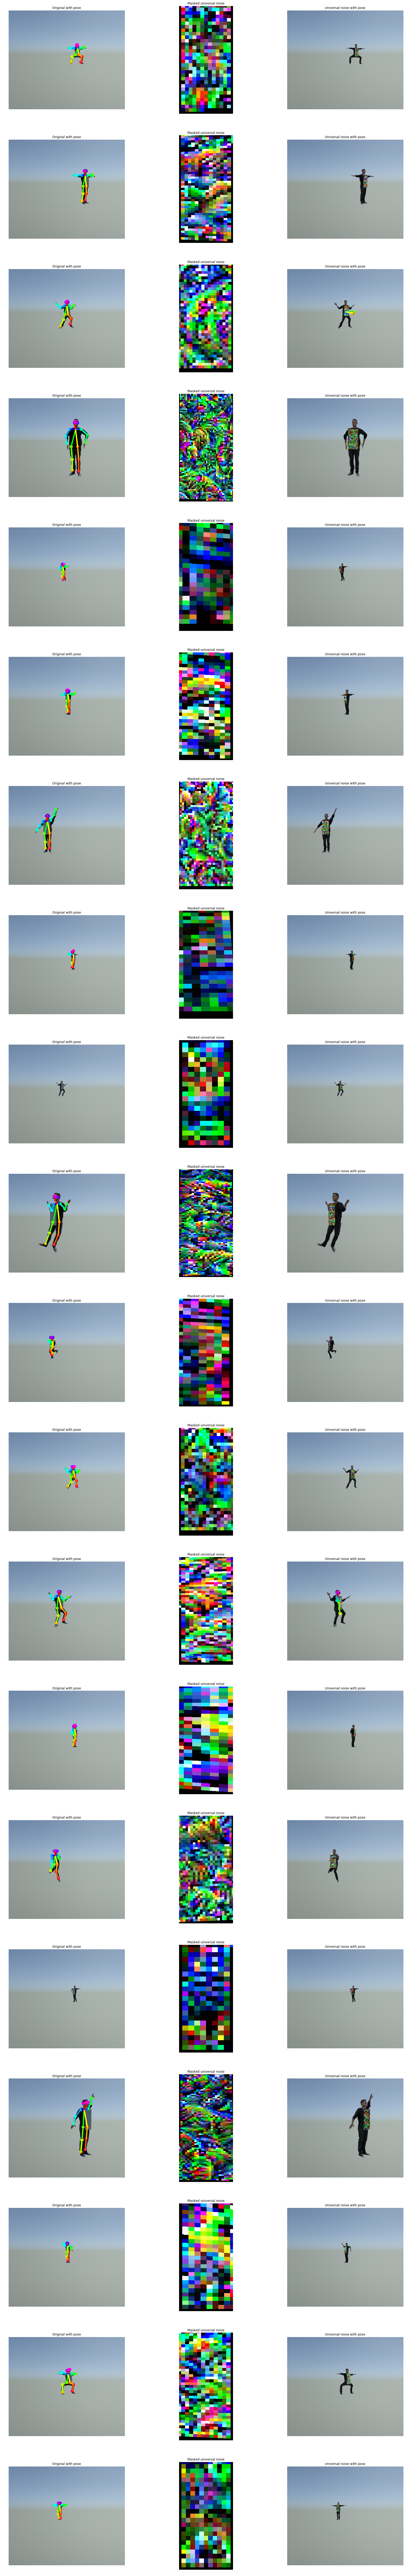

In [31]:
# Plot attributions
%matplotlib inline
n_cols = 3
n_rows = len(image_targets)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(
    3*n_cols*fig_scale, 3*n_rows*fig_scale))

plot_cnt = 0

for i, xi in enumerate(image_targets):
    detections = estimator.inference(xi, resize_to_default=True, upsample_size=RESIZE_OUT_RATIO)
    detections_result = TfPoseEstimator.draw_humans(xi, detections, imgcopy=True)
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(cv2.cvtColor(detections_result, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Original with pose')
    ax.axis('off')
    plot_cnt += 1
    
    universal_noise = universal_noises[i]
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(universal_noise / 255.0)
    ax.set_title(f'Masked universal noise')
    ax.axis('off')
    plot_cnt += 1
    
    
    transforms = [image_transforms[i]]
    universal_noise = [universal_noise ]
    detections_noise = estimator.inference(
        xi, 
        resize_to_default=True, 
        upsample_size=RESIZE_OUT_RATIO, 
        transforms=transforms,
        universal_noise=universal_noise,
        mask=[image_masks[i]]
    )
    print('draw_humans_warped')
    detections_result_noise = estimator.draw_humans_warped([xi], detections_noise, universal_noise, transforms, [image_masks[i]])
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(cv2.cvtColor(np.clip(detections_result_noise, 0, 255), cv2.COLOR_BGR2RGB) / 255.0)
    ax.set_title(f'Universal noise with pose')
    ax.axis('off')
    plot_cnt += 1
    
    